## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [0]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, mode=0, output_units=10, num_neurons=[512, 256, 128]):
    
    
    ## Normal mode
    if mode==0:
        input_layer = keras.layers.Input(input_shape)
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
                x = keras.layers.BatchNormalization()(x)
                
    ## BN before Activation
    if mode==1:
        input_layer = keras.layers.Input(input_shape)
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(input_layer)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            else:
                x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
    
    ## BN after input
    if mode==2:
        input_layer = keras.layers.Input(input_shape)
        x = keras.layers.BatchNormalization()(input_layer)
        for i, n_units in enumerate(num_neurons):
                x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
          
    output_layer = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    adam = keras.optimizers.Adam(lr=1e-1)
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
batch_size = [512, 256, 128]
epochs = 10
mode = [0, 1, 2]

In [23]:
results = {}

for m in mode:
    for b in batch_size:
        model = build_mlp(x_train.shape[1:], m)
        print(f'Mode: {m}, batch_size: {b}')
        model.summary()
        history = model.fit(x_train, y_train, batch_size=b, epochs=epochs, verbose=1, shuffle=True, validation_data=(x_test, y_test))
        
        # Collecting accuracy/loss
        train_loss = history.history['loss']
        test_loss = history.history['val_loss']
        train_acc = history.history['acc']
        test_acc = history.history['val_acc']
        
        tag = "Mode %s -- batch_size: %s" %(str(m), str(b))
        results[tag] = {"train_loss": train_loss,
                        "test_loss": test_loss,
                        "train_acc": train_acc,
                        "test_acc": test_acc
                       }

Mode: 0, batch_size: 512
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_56 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_57 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_58 (Batc (None, 128)           

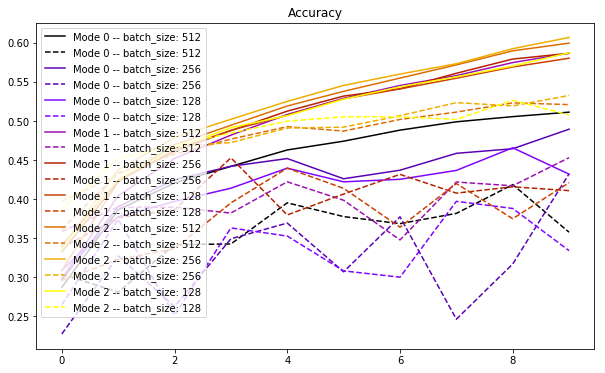

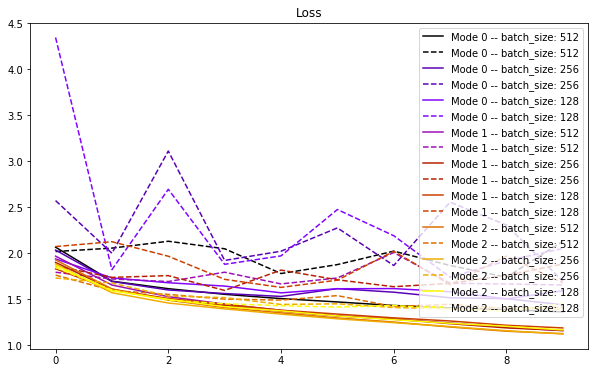

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(results))]

plt.figure(figsize=(10, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(results[cond]['train_acc'], '-', label=cond, color=colors[i])
    plt.plot(results[cond]['test_acc'], '--', label=cond, color=colors[i])
plt.title("Accuracy")
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(10, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=colors[i])
    plt.plot(range(len(results[cond]['test_loss'])),results[cond]['test_loss'], '--', label=cond, color=colors[i])
plt.title("Loss")
plt.legend(loc="upper right")
plt.show()

In [25]:
loss, acc = model.evaluate(x_test, y_test)
print(f'Accuracy: {acc}')
print(f'Loss: {loss}')

10000/10000 [==============================] - 3s 283us/step
Accuracy: 0.5076
Loss: 1.4519749797821044
